# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Starbucks Capstone Project
#### Mike Durrant

## Read in data files for exploratory data analysis

In [35]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
from matplotlib import pyplot as plt

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Portfolio exploration

In [7]:
portfolio   # 10 offer ids; channels will need breaking out into separate columns with 1 or 0

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


### Portfolio discussion
There are only 10 distinct offer ids in this experiment.  The channels applicable to each offer will need to be broken out into separate columns with 1 or 0 to flag which channel was in play.  There may be scope to group some of these offers (e.g. by offer type) - however, with only 10 on the list, it may be sensible to treat them separately for analysis.

## Profile exploration

In [39]:
profile  # 17,000 customer profiles - need to check for duplicates; check for normal distribution on age and income; check nans

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [63]:
# Check for duplicates in the id column
profile['id'].duplicated().sum()

0

### Profile duplicates discussion
There are no duplicates in the customer profile id column.  It is possible that a customer could be on this list twice if they signed up on separate occasions (perhaps with a different email account).  However, with the information provided we could not accurately identify those duplicates. Further data, such as name, street address, postcode (zip code), email address, telephone number, could be used to carry out a more thorough de-duplication process.  This information would need to be treated with additional security measures as it would constitute PII (Personally Identifiable Information) and would likely be affected by local legal frameworks e.g. European GDPR.

In [26]:
# What values are present in the data for gender?
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [40]:
# Frequency of each gender value - excl NaNs
gender_counts = profile['gender'].value_counts()
gender_counts

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [46]:
# Count of NaNs
gender_nans_count = profile['gender'].isna().sum()
gender_nans_count

2175

In [48]:
# Check this covers the full 17,000 rows --- it does.
gender_counts.sum() + gender_nans_count

17000

### Gender discussion
Gender will likely be split out using one hot encoding later into three or four columns.  We will need to decide whether to drop NaNs or to keep them as a further one hot encoded field ('not providing gender' may yield a useful feature in itself).

## Age exploration

In [33]:
# Check value counts of ages
profile['age'].value_counts()

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

(array([ 205.,  275.,  257.,  275.,  296.,  266.,  244.,  291.,  265.,
         372.,  354.,  391.,  442.,  423.,  444.,  609.,  647.,  723.,
         709.,  695.,  767.,  642.,  656.,  591.,  601.,  501.,  482.,
         400.,  352.,  296.,  252.,  234.,  207.,  153.,  120.,  117.,
          99.,   69.,   55.,   21.,   10.,   17.,    0.,    0.,    0.,
           0.,    0.,    0.,    0., 2175.]),
 array([ 18.,  20.,  22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,
         40.,  42.,  44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,
         62.,  64.,  66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,
         84.,  86.,  88.,  90.,  92.,  94.,  96.,  98., 100., 102., 104.,
        106., 108., 110., 112., 114., 116., 118.]),
 <a list of 50 Patch objects>)

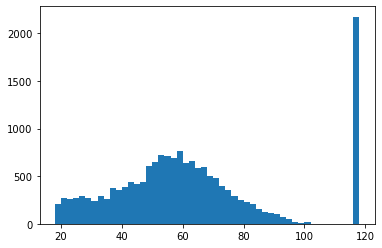

In [49]:
# Check for distribution of ages
plt.hist(profile['age'], bins=50)      # clear outlier at age 118 with 2,175 customers - these will need to be ignored

In [54]:
# Check for NaNs in ages
profile['age'].isna().sum()  # there are no NaNs

0

In [65]:
# What is the minimum age in the dataset
profile['age'].min()

18

### Age discussion
Presumably date of birth is a mandatory input field, but the "118 year olds", of which there are 2,175, left the field blank and it defaulted to 01/01/1900 for D.O.B.  In our modelling we will need to make these users NaNs which can either be excluded from a model, or included in case they are a useful feature in themselves (e.g. customers who choose not to give their date of birth may respond in a particular way to promotions as well).

Otherwise age seems to have a reasonably sensible distribution.  The minimum age is 18.  Is this the minimum age for signing up for an account?  Also of note, the frequency is highest in the 50 - 60 age category and is then almost normally distributed, although there is a noticeably higher frequency on the left side (younger customers) compared to the right side where it drops away quite steeply.  With access to additional data it would be advisable to compare this distribution with that of the overall population of Starbucks customers to confirm that the sample in this experiment is in line and not suffering from sampling bias.

## Transcript exploration

In [22]:
transcript   # 306,534 rows of transcript data split into different event types

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


The dict in the value column will need to be split out to gather useful data for modelling.  The time represents hours since the start of the experiment.  714 hours relates to nearly 30 days overall.

In [67]:
# What are the different event types in the dataset
transcript['event'].unique()     # 4 types of event in the transcript

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [68]:
# How frequently does each event type occur
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

## Key Exploration Headlines
* 10 distinct offers
* 17,000 customer profiles
* circa 300,000 transcript lines to analyse
    * circa 140,000 transactions
    * circa 76,000 offers received
    * circa 58,000 offers viewed
    * circa 34,000 offers completed (xxxx of which were not viewed prior to completion)